In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5
!pip install sentencepiece

In [3]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import gc

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train_prep", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val_prep", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [6]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [7]:
#Load the tokenizer for the T5-base model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

In [8]:
#Try out the tokenizer
text = "How are you feeling today?"
enc = tokenizer.encode_plus(text)
print(enc)

{'input_ids': [571, 33, 25, 1829, 469, 58], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [9]:
#See how the labels are encoded
labels = ["no", "weak", "strong"]
for lab in labels:
  print(tokenizer.encode(lab))

[150]
[5676]
[1101]


In [10]:
class EmpathyDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "score"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = str(target) + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

###Train the T5 model

In [11]:
#load the tokenizer for this model
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [12]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'val_prep', 512)

In [13]:
#show a sample
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i feel the same way at least i did for a while i talked to my doctor a couple years ago and basically i learned that depression is a mental illness and you can literally have no reason to be depressed like myself and still feel like absolute shit and want to cry all the time im pretty sure we were just born with it and you can only treat it i myself am still trying to fight it but its only been maybe like 8 years so im sure it will get better eventually just stay strong my dude if you ever need anyone talk to you can pm me i stay up all hours of the night on the east coast
weak


In [14]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [15]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=1e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=16,
    gradient_accumulation_steps=2,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, 
    opt_level='O1',
    max_grad_norm=1.0,
    seed=42,
)

In [16]:
args_dict.update({'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'num_train_epochs':16})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'drive/MyDrive/empathy_classifier_data/', 'output_dir': 'drive/MyDrive/t5_empathy', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0001, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 16, 'gradient_accumulation_steps': 2, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [17]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

In [18]:
def get_dataset(tokenizer, type_path, args):
  return EmpathyDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [19]:
#create instance of model
model = T5FineTuner(args)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

In [20]:
trainer = pl.Trainer(**train_params)

In [21]:
#train loop
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

###Test set evaluation

In [22]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [23]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data', 'test_prep', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [24]:
it = iter(loader)

In [25]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [26]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [27]:
#print some predictions
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual label: %s" % targets[i])
    print("predicted label: %s" % dec[i])
    print("=====================================================================\n")

text: yah professionals dont give a fuck pisses me off when someone says go see a therapist no bitch
i need some love because im broken from an abusive past bullying and that the fact is no one wants
to do or associate anything with me if i reveal my true self are you gonna take the prozac

Actual label: no
predicted label: no

text: hope that things will get better

Actual label: no
predicted label: weak

text: so sorry that you are going through this as well is there anyone you might be able to talk
with i know waking up in the morning with thoughts of suicide can just ruin a day maybe if able you
can try to do something fun or relaxing when you get home i know it probably help right now but
maybe it can help ease the thoughts for a bit i wish i knew something that you could do while at
work but i sorry if you want to talk feel free to pm me also at work with the same thoughts

Actual label: strong
predicted label: strong

text: im always here for you

Actual label: weak
predicted la

In [28]:
dataset = EmpathyDataset(tokenizer, 'drive/MyDrive/empathy_classifier_data/', 'test_prep', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
for i, out in enumerate(outputs):
  if out not in labels:
    print(i, 'detected invalid prediction')
    del outputs[i]
    del targets[i]

In [30]:
#other metrics
print(metrics.classification_report(targets, outputs, digits=4))

              precision    recall  f1-score   support

          no     0.8980    0.8111    0.8523       217
      strong     0.9749    1.0000    0.9873       194
        weak     0.8243    0.8883    0.8551       206

    accuracy                         0.8963       617
   macro avg     0.8991    0.8998    0.8982       617
weighted avg     0.8976    0.8963    0.8957       617



####Confusion matrix

In [31]:
torch.save(model.state_dict(), 'drive/MyDrive/t5_empathy_finetuned.pt')

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
cm = metrics.confusion_matrix(targets, outputs)

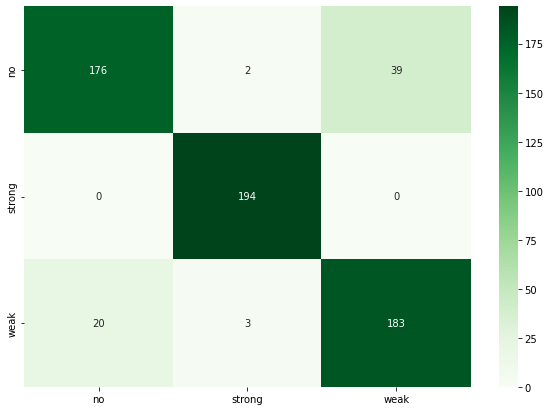

In [34]:
df_cm = pd.DataFrame(cm, index = ["no", "strong", "weak"], columns = ["no", "strong", "weak"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')

In [35]:
#define get_empathy_score function to generate individual prediction

def empathy_score(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt').cuda()

  output = model.model.generate(input_ids=input_ids, max_length=2).cuda()

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]

  if label == 'no':
    score = 0
  elif label == 'weak':
    score = 1
  else:
    score = 2
    
  return score

In [36]:
test_path = "drive/MyDrive/empathy_classifier_data/test_prep.txt"
test_data = pd.read_csv(test_path, sep=";", header=None, names=['text', "class"])

In [39]:
import time
start_time = time.time()
for i in range(len(test_data['text'])):
  empathy_score(test_data.iloc[i].iat[0])
print(time.time() - start_time)

17.236726999282837
